In [14]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from matplotlib.colors import ListedColormap

# Decision Tree Classifier: Create and Train the model
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
import pandas_datareader as pdr  # ดึงข้อมูลจากที่อื่นได้หมด
import random, warnings
from sklearn.datasets import load_boston

import matplotlib
import seaborn as sns
import statsmodels.api as sm  # pip install statsmodels
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
import talib

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import absolute
from numpy import sqrt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [15]:
pd.options.display.float_format = "{:,.3f}".format
warnings.simplefilter(action='ignore', category=FutureWarning)
random.seed(123)

In [30]:
# download dataframe
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']
NUM_DAYS = 730      # จำนวนวันย้อนหลังที่จะดึงข้อมูล
INTERVAL = '1d'     # อัตราตัวอย่างข้อมูลย้อนหลัง
symbol = '^DJI'      # สัญลักษณ์ของหุ้น
start = (datetime.date.today() - datetime.timedelta( NUM_DAYS ) ) #4 ปี
end = datetime.datetime.today()

DJI = yf.download(symbol, start='2019-12-04', end='2021-12-04', interval=INTERVAL)
DJI

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-03,"27,501.980","27,524.740","27,325.131","27,502.811","27,502.811",275350000
2019-12-04,"27,634.631","27,727.449","27,612.080","27,649.779","27,649.779",218200000
2019-12-05,"27,736.051","27,745.199","27,562.801","27,677.789","27,677.789",208600000
2019-12-06,"27,839.680","28,035.850","27,839.680","28,015.061","28,015.061",223310000
2019-12-09,"27,987.051","28,010.420","27,906.141","27,909.600","27,909.600",217000000
...,...,...,...,...,...,...
2021-11-29,"35,017.711","35,287.910","34,895.891","35,135.941","35,135.941",416040000
2021-11-30,"35,056.988","35,056.988","34,424.441","34,483.719","34,483.719",678800000
2021-12-01,"34,678.941","35,004.641","34,006.980","34,022.039","34,022.039",496000000


In [31]:
def get_indicator(data):
    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema15'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['Volume'] / data['Volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['Open'])
    del (data['High'])
    del (data['Low'])
    del (data['Volume'])
    del (data['Adj Close'])
    
    return data

data = get_indicator(DJI)
print(DJI.columns)
data.fillna(method='bfill',inplace=True)
data

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


,Close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol
Date,,,,,,,,,,,,,,,,,,,,
2019-12-03,"27,502.811",100.000,0.000,0.000,88.037,"214,848,438.356",195.562,764.350,74.007,3.178,"218,200,000.000",66.667,57.492,0.609,1.259,1.000,1.000,1.000,1.000,1.000
2019-12-04,"27,649.779",100.000,3.297,1.832,88.037,"139,251,035.319",195.562,764.350,74.007,3.178,"218,200,000.000",66.667,57.492,0.609,1.259,1.003,1.003,1.003,1.002,0.894
2019-12-05,"27,677.789",100.000,5.070,3.159,88.037,"193,663,765.006",195.562,764.350,74.007,3.178,"426,800,000.000",49.584,57.492,0.609,1.259,1.002,1.002,1.002,1.002,0.907
2019-12-06,"28,015.061",100.000,17.929,8.162,88.037,"369,643,312.891",195.562,764.350,74.007,3.178,"650,110,000.000",133.333,57.492,0.609,1.259,1.011,1.011,1.010,1.010,0.980
2019-12-09,"27,909.600",81.183,20.343,11.786,88.037,"167,039,259.773",195.562,764.350,74.007,3.178,"433,110,000.000",79.200,57.492,0.609,1.259,1.006,1.005,1.005,1.004,0.965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-29,"35,135.941",39.845,-25.970,124.382,23.161,"8,778,208,957.341",331.415,-964.367,50.584,-2.616,"15,439,980,000.000",-204.145,-129.937,1.172,0.683,1.002,0.989,0.986,0.987,1.171
2021-11-30,"34,483.719",31.663,-115.419,76.422,3.084,"8,226,632,606.774",363.726,"-1,603.730",46.678,-4.002,"14,761,180,000.000",-235.134,-142.843,1.160,0.638,0.984,0.972,0.970,0.974,1.658
2021-12-01,"34,022.039",27.377,-221.014,16.935,0.652,"7,745,605,766.628",410.908,"-2,120.180",44.967,-5.757,"14,265,180,000.000",-225.614,-166.474,1.139,0.635,0.971,0.961,0.960,0.967,1.171


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

cols = list(data.drop("Close", axis=1).columns)
X = data.drop("Close", axis=1).values  # Feature Matrix
y = data["Close"].values
rfe = RFE(estimator=LinearRegression())
rfe.fit(X,y)
print(rfe.support_)
print(rfe.ranking_)

temp = pd.Series(rfe.support_, index = cols)
selected_features_rfe = temp[temp==True].index
selected_features_rfe

[False False False False False False False  True  True False False False
  True  True  True  True  True  True  True]
[ 3  8  6  4 11  5  9  1  1 10  7  2  1  1  1  1  1  1  1]


Index(['14 period MFI', 'ROC', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5',
       'normVol'],
      dtype='object')

In [33]:
datapredict = data[selected_features_rfe].join(data['Close'])
datapredict

,14 period MFI,ROC,VIm,VIp,ema50,ema21,ema15,ema5,normVol,Close
Date,,,,,,,,,,
2019-12-03,74.007,3.178,0.609,1.259,1.000,1.000,1.000,1.000,1.000,"27,502.811"
2019-12-04,74.007,3.178,0.609,1.259,1.003,1.003,1.003,1.002,0.894,"27,649.779"
2019-12-05,74.007,3.178,0.609,1.259,1.002,1.002,1.002,1.002,0.907,"27,677.789"
2019-12-06,74.007,3.178,0.609,1.259,1.011,1.011,1.010,1.010,0.980,"28,015.061"
2019-12-09,74.007,3.178,0.609,1.259,1.006,1.005,1.005,1.004,0.965,"27,909.600"
...,...,...,...,...,...,...,...,...,...,...
2021-11-29,50.584,-2.616,1.172,0.683,1.002,0.989,0.986,0.987,1.171,"35,135.941"
2021-11-30,46.678,-4.002,1.160,0.638,0.984,0.972,0.970,0.974,1.658,"34,483.719"
2021-12-01,44.967,-5.757,1.139,0.635,0.971,0.961,0.960,0.967,1.171,"34,022.039"


In [34]:
pred_future_days = 30
datapredict = data
datapredict['pred'] = datapredict[['Close']].shift(-pred_future_days)
X = np.array(datapredict.drop(['pred'],1))[:-pred_future_days]
y = np.array(datapredict['pred'])[:-pred_future_days]
X_train, X_test, y_train, y_test = train_test_split( X , y, test_size=0.15, random_state=0)

LR = LinearRegression()
LR.fit(X_train, y_train)

future_pred = datapredict.drop(['pred'],1)[:-pred_future_days]
future_pred = future_pred.tail(pred_future_days)
future_pred = np.array(future_pred)

LR_prediction = LR.predict(future_pred)
LR_prediction

predictions = LR_prediction

valid = datapredict[X.shape[0]:]
valid['pred'] = predictions

C:\Users\USER\AppData\Local\Temp/ipykernel_13420/470962726.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = predictions


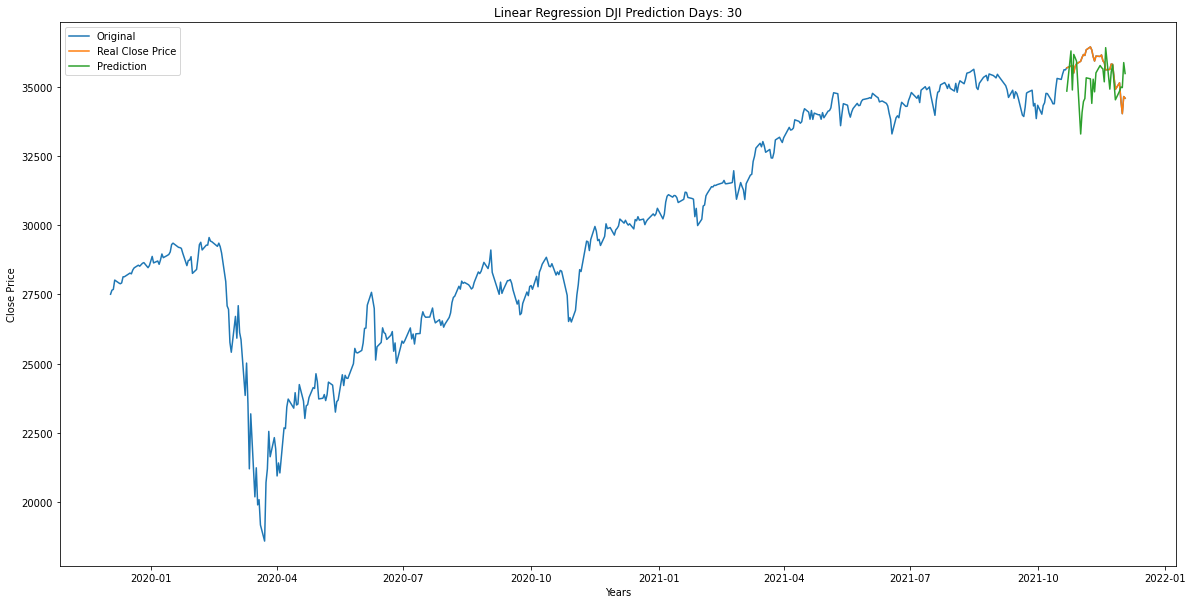

In [35]:

plt.figure(figsize=(20,10))
plt.title('Linear Regression DJI Prediction Days: %d' %pred_future_days)
plt.xlabel('Years')
plt.ylabel('Close Price')
plt.plot(data['Close'])
plt.plot(valid[['Close','pred']])
plt.legend(['Original','Real Close Price','Prediction'])
plt.show()

In [36]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)

#use k-fold CV to evaluate model
r2_scores_lr = cross_val_score(LR, X_train, y_train, scoring='r2',
                         cv=cv, n_jobs=-1)

#view r2 score
print(mean(absolute(r2_scores_lr)))

0.8652400223983223


In [37]:
rmse_scores_lr = cross_val_score(LR, X_train, y_train, scoring='neg_root_mean_squared_error',
                         cv=cv, n_jobs=-1)

#view rmse score
print(rmse_scores)
print(mean(absolute(rmse_scores_lr)))

[-1214.01113395 -1737.20187676 -1410.87488568 -1184.24269974
 -1117.00810898]
1517.4524324911868


Polynomail regression

C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.16661e-43): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\USER\AppData\Local\Temp/ipykernel_13420/2195457383.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = predictions


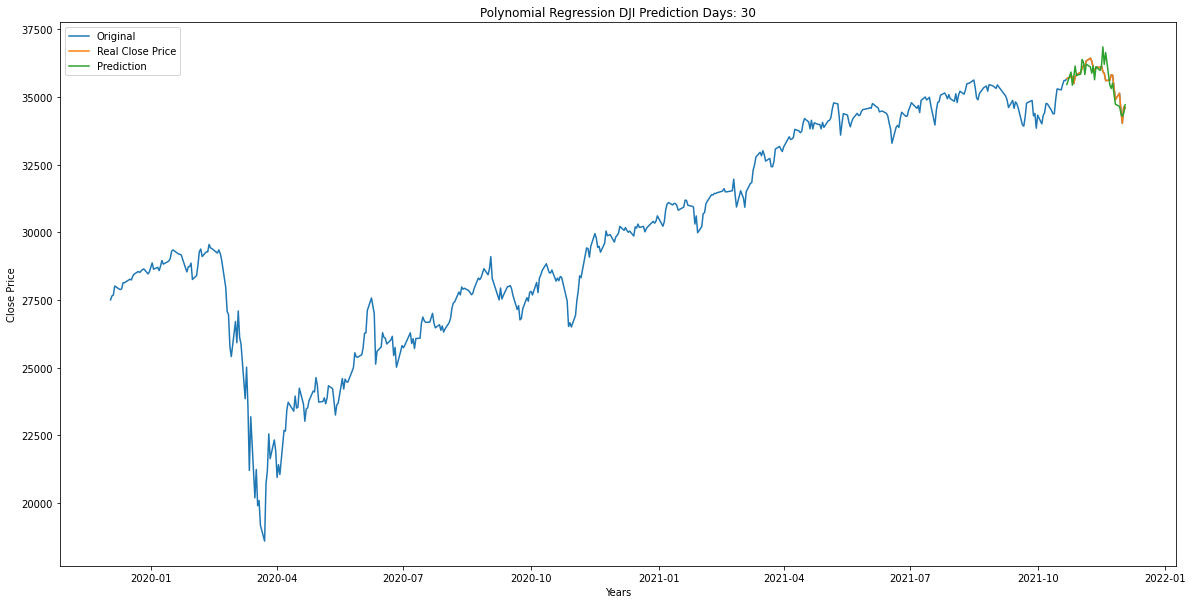

In [38]:

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pred_future_days = 30
datapredict = data
datapredict['pred'] = datapredict[['Close']].shift(-pred_future_days)
X = np.array(datapredict.drop(['pred'],1))[:-pred_future_days]
y = np.array(datapredict['pred'])[:-pred_future_days]
X_train, X_test, y_train, y_test = train_test_split( X , y, test_size=0.15 , random_state=0)

# OLS = sm.OLS(y_train,X_train).fit()

# features = PolynomialFeatures(degree=5)
# X_train_poly = features.fit_transform(X_train)
# X_test_poly = features.fit_transform(X_test)
# POLY = LinearRegression()
# POLY.fit(X_train_poly, y_train)
POLY = make_pipeline(PolynomialFeatures(2), Ridge())
POLY.fit(X_train, y_train)

future_pred = datapredict.drop(['pred'],1)[:-pred_future_days]
future_pred = future_pred.tail(pred_future_days)
future_pred = np.array(future_pred)

POLY_prediction = POLY.predict(future_pred)

predictions = POLY_prediction

valid = datapredict[X.shape[0]:]
valid['pred'] = predictions

plt.figure(figsize=(20,10))
plt.title('Polynomial Regression DJI Prediction Days: %d' %pred_future_days)
plt.xlabel('Years')
plt.ylabel('Close Price')
plt.plot(data['Close'])
plt.plot(valid[['Close','pred']])
plt.legend(['Original','Real Close Price','Prediction'])
plt.show()

In [39]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)

#use k-fold CV to evaluate model
r2_scores_poly = cross_val_score(POLY, X_train, y_train, scoring='r2',
                         cv=cv, n_jobs=-1)

#view r2 score
print(r2_scores)
print(mean(absolute(r2_scores_poly)))

[0.8777279  0.80530511 0.84978909 0.91340336 0.9032486 ]
0.9034659589699606


In [40]:
rmse_scores_poly = cross_val_score(POLY, X_train, y_train, scoring='neg_root_mean_squared_error',
                         cv=cv, n_jobs=-1)

#view rmse score
print(rmse_scores)
print(mean(absolute(rmse_scores_poly)))

[-1214.01113395 -1737.20187676 -1410.87488568 -1184.24269974
 -1117.00810898]
1256.8752794336228


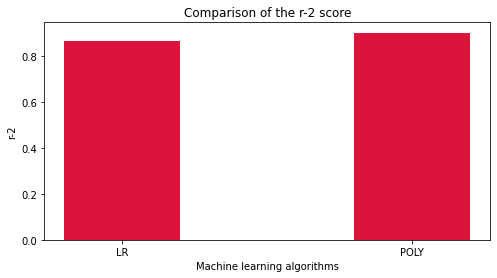

In [41]:
data = {'LR':np.mean(absolute(r2_scores_lr)), 'POLY':np.mean(absolute(r2_scores_poly))}

courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (8, 4))
 
# creating the bar plot
plt.bar(courses, values, color ='crimson',
        width = 0.4)
 
plt.xlabel("Machine learning algorithms")
plt.ylabel("r-2")
plt.title("Comparison of the r-2 score")
plt.show()